# Lab Tutorial 07 (Solved)

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)

# Google Colab Setup
Before starting the tutorial, we need to run a few commands to set up our environment on Google Colab. To this end, make sure to have first gone through the **"Software setup guide"** document uploaded on Moodle. Also, if you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store the lab materials for this tutorial!), and follow the instructions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, we will update OpenCV. Note: don't worry about the following error:
```
ERROR: pip's dependency resolver...
```

In [2]:
!pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


If the above cell present you with a button to "Restart runtime" or similar, press it in order to finalise the package upgrade.

You can check that the correct version is now installed:

In [3]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: numpy, numpy, numpy
Required-by: dopamine-rl, imgaug


Now recall the path in your Google Drive where you uploaded the lab materials, fill it in below and run the cell:

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision lab tutorials/Lab 07' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

If everything is working correctly then running the folowing cell should print the filenames from the lab materials folder:

```
['Lab_07_Solved.ipynb', 'Lab_07.ipynb', '101_Caltech_Subset.zip']
```

**Important**: so far, during the lab tutorials, you have always mounted your Google Drive to Colab, so that you could access the data stored there. However, this means that each time you access a file from Google Drive, Colab needs to go and create a temporary copy of it. While this is not a problem in general, it becomes a slow and cumbersome process when dealing with many files. 

In this lab tutorial, we will be **dealing with an actual dataset** (`101_Caltech_Subset.zip`). As a consequence, it's wise to **copy and unzip it directly on the Colab server**, which will make accessing the data much faster. To do this, we will use the following few lines of code:

In [5]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, '101_Caltech_Subset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q 101_Caltech_Subset.zip

# Delete zipped version from Colab (not from Drive)
!rm 101_Caltech_Subset.zip

If the process was successful, by clicking on the *Files* folder in the toolbar on the left side, you should be able to see a *101_Caltech_Subset* folder (you might need to hit the *Refresh* icon above). Explore it, and notice how the different images are divided into subfolders based on their class label.

This is just a subset of the whole dataset: the whole set can be found [here](https://cityuni-my.sharepoint.com/:u:/g/personal/giacomo_tarroni_city_ac_uk/EYHUTX9pRUhKm2FACp_XPTMBgFnK7oQoYefsmK-FoOJn_Q?e=VNd9nh): feel free to download it and test your algorithms on it!

# Introduction

In this lab tutorial, we will learn how to perform **image classification using a Bag of Visual Words (BoVW) approach**. To test it, we will use a subset of the **101_Caltech dataset**. Then, we will perform **image classification on the MNIST digit dataset using a multi-layer perceptron (MLP)**.

# 1: Image classification with Bag of Visual Words

In the lecture, we have introduced the **Bag of Visual Words (BoVW)** approach, which was adapted to computer vision from the world of natural language processing (NLP). Since images do not actually contain discrete words, we will need to construct a "vocabulary" of feature descriptors called *codewords* representative of each image category. More in particular, the main steps required to train a BoVW model are the following:

1. Detection (or "forced" assignment using a fixed grid) of interest points on each image
2. Extraction of features descriptors (e.g. SIFT, SURF) for each point
3. Clustering (usually using K-means) of feature descriptors in order to create codewords
4. Generation of histograms of codewords for each image
5. Training of a classifier (e.g. SVM) using the histograms

At test time, the same steps are executed, apart from the clustering step. In addition, the trained classifier is used to predict a class for each image.

To test this approach, we will use a subset of the famous **101 Caltech dateset**. This dataset was collected by Fei-Fei Li, Marco Andreetto and Marc Aurelio Ranzato. The full dataset (available for you to download here) includes 100 classes of objects plus a background category. **Each class contains between 31 to 800 color images of different sizes**. The size of each image is approximately 300 × 200 pixels on average. We will use a subset of this dataset consisting of only 6 categories (but feel free to [experiment with the whole dataset](https://cityuni-my.sharepoint.com/:u:/g/personal/giacomo_tarroni_city_ac_uk/EYHUTX9pRUhKm2FACp_XPTMBgFnK7oQoYefsmK-FoOJn_Q?e=VNd9nh) later on your own!). 

Let's start by importing some relevant modules:

In [6]:
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

%matplotlib inline

We will now define a simple function to load the images and their respective labels. This function will also allow to select a subset of classes (from the 6 available):

In [9]:
def import_selected_data(path, label_list=None):
    """Load images and labels from selected directories"""
    images = []
    labels = []

    if label_list is None:
        folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('.')]
    else:
        folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list]

    for folder in folder_names:
        file_names = [file for file in sorted(os.listdir(os.path.join(path, folder))) if file.endswith('.jpg')]
        for file in file_names:
            images.append(io.imread(os.path.join(path, folder, file)))
            labels.append(folder)

    return images, labels

Now we can use this function to actually import the data. At this time, we will focus on 3 classes only: `'bonsai', 'ferry', 'laptop'`.

In [10]:
X, y = import_selected_data('101_Caltech_Subset', label_list=['bonsai', 'ferry', 'laptop'])

When dealing with an unknown dataset, it's always extremely important to inspect the sample distribution among the different classes. This can be done very easily using `Counter`:

In [11]:
print(Counter(y))

Counter({'bonsai': 128, 'laptop': 79, 'ferry': 65})


Such an **unbalanced dataset is problematic**, because it can lead to biases at test time (i.e. higher chances to predict the class with more training samples). In our implementation, we will use the `sklearn.model_selection.train_test_split` function to create a train and test data split, and we will handle the class imbalance by simply using the `stratify` parameter, which will guarantee that the label distribution is maintained in both data splits (more info on the online documentation).

However, to properly rebalance the dataset, you should consider using the [`imbalanced learn`](https://github.com/scikit-learn-contrib/imbalanced-learn) package. [Here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) you can find a handy tutorial.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y)

Now we can start with **step 1 and 2**: **interest point detection** and **feature descriptors extraction**. 

In this implementation, **we will use SIFT for both these steps**. More specifically, the `for` cycle in the next cell takes care of localising interest points and extracting a list of feature descriptors from each image of the training set. This list of descriptors is then appended to a list called `des_list`, and the same happens for the image labels. Note that the number of interest points, and consequently of descriptors in the list, varies among the different images. 

The cell also **displays the interest point locations for the first 4 images**.

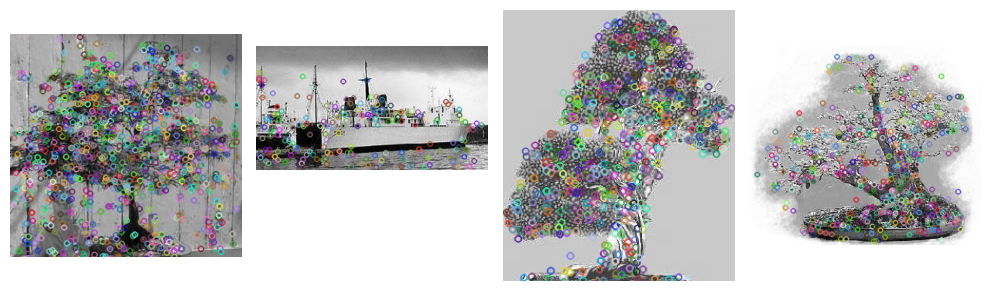

In [13]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

Note that **if you instead wanted to extract the interest points using a fixed grid** (which often leads to a better final accuracy), you would need to create a list of keypoints using `cv2.KeyPoint` and then extract the descriptors with `sift.compute(img, kp)`. 

Also, don't worry for potential warnings about colour conversions: this is due to some images being already in grayscale in the training set.

Let's now move to **step 3**: **clustering of the descriptors** to create codewords. We will use **K-means** to do so. Two things to note:

- The **number of clusters** `k` **is a hyper-parameter** that you should tune using an evaluation set. A good rule of thumb (that you can use as a starting point) is to use 10 times the number of classes in your dataset. In this implementation, we'll simply stick to this number. In general, you should familiarise with hyper-parameter tuning, starting from [this guide](https://scikit-learn.org/stable/modules/grid_search.html);
- When dealing with a very large number of data points (which, in this context, are the feature descriptors, not the images), `sklearn.cluster.KMeans` **can take a very long time to converge**. In these cases, `sklearn.cluster.MiniBatchKMeans` is instead suggested: it runs essentially the same algorithm, but using a different subset (i.e. a batch) of the points at each iteration. `MiniBatchKMeans` is usually suggested when dealing with more than 10,000 samples, but we will use it here anyway. Note that in this case, the size of the batches is also a hyper-parameter. For more information on `MiniBatchKMeans`, please refer to [this guide](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans).

In [15]:
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

Now it's time for **step 4**: **generating histograms of codewords**, one for each image:

In [16]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

This step consists in representing the descriptors of a given image with their closest codewords, thus translating each image into an histogram of codewords. Note that the entries to the histogram are normalised by the number of keypoints in an image, in order to harmonise images with a different number of keypoints.

We can now plot the overall histogram for the codewords, showing their occurrence in the training set:

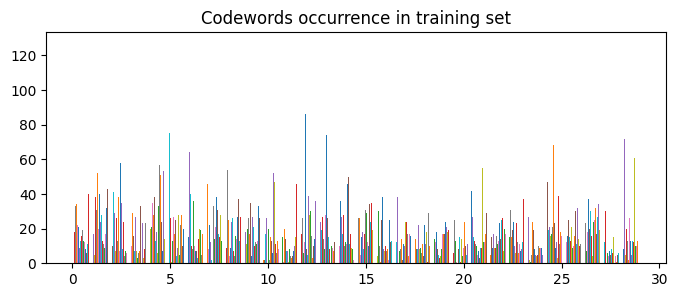

In [17]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list, dtype=object), bins=k)
ax.set_title('Codewords occurrence in training set')
plt.show()

And finally, **step 5**: **training a classifier**. We'll use an **SVM with radial basis function kernel**.

In [18]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf')

# We learn the digits on the first half of the digits
classifier.fit(hist_array, y_train_list)

SVC()

This concludes the training of the BoVW model.

We can now **move to the test set** and estimate the accuracy of the model. To do so, we need to detect interest points, extract feature descriptors and associate histograms of codewords from each image of the test set:

In [19]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

We can now use our classifier to predict the classes of each test image:

In [20]:
y_pred = classifier.predict(hist_array).tolist()

Let's compare ground-truth labels and predicted classes on a few images:

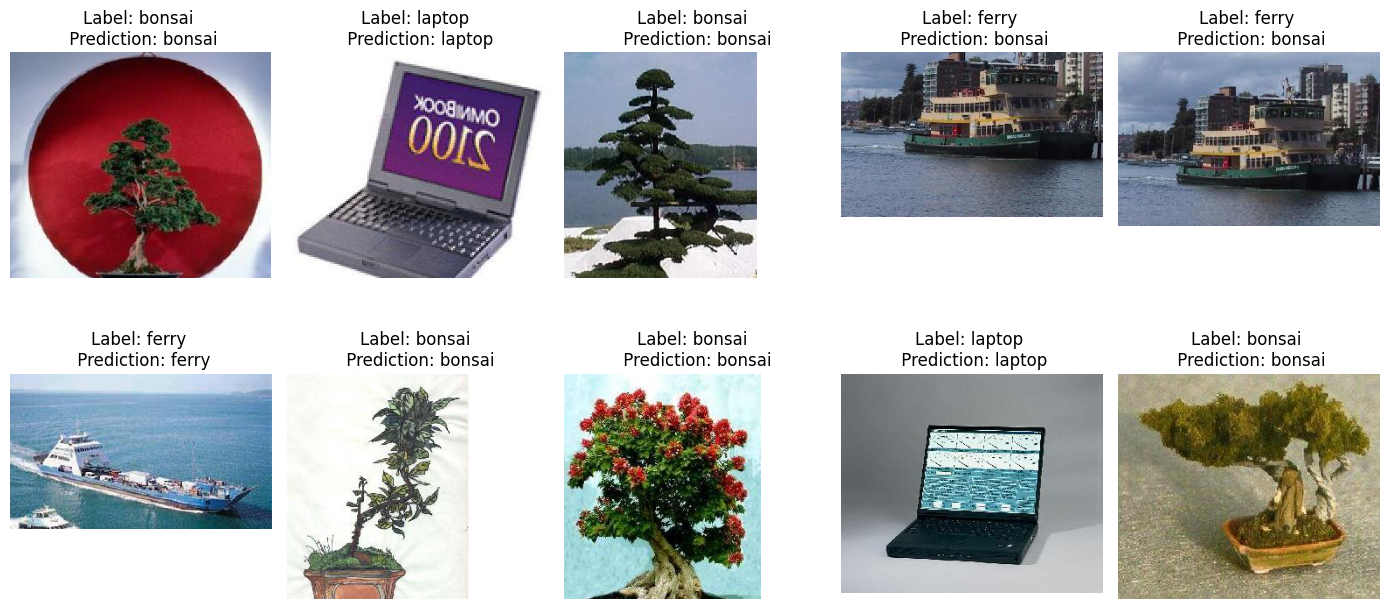

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

Finally, we can now run a quantitative analysis of the model's performance:

In [22]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

      bonsai       0.90      1.00      0.95        26
       ferry       1.00      0.69      0.82        13
      laptop       0.94      1.00      0.97        16

    accuracy                           0.93        55
   macro avg       0.95      0.90      0.91        55
weighted avg       0.93      0.93      0.92        55




## Task 1.1: Changing hyper-parameters

There are several hyper-parameters and settings that are involved in the definition of the BoVW model. **Change the SVM's kernel and C, as well as other hyper-parameters**: can you outperform the previous model?

**Important**: note that in this case we are tuning the hyper-parameters by assessing their impact on the test set, which is **extremely bad practice** and usually leads to an over-estimation of a model's accuracy. The proper experimental set-up would require to create an evaluation set from the training one (potentially using cross-validation) and using that to perform hyper-parameter tuning. Always remember: the test set should be used only once, at the end. In addition, hyper-parameter tuning should be performed in a systematic way, as you can see in [this guide](https://scikit-learn.org/stable/modules/grid_search.html).

For the sake of this tutorial, however, we will go ahead with the current set-up.

In [23]:
##############################################################################
# TODO: Change hyper-parameters for the BoVW model                           #
##############################################################################
# Double k for K-means, set SVM's C to 0.8 and kernel to 'poly'

# Use MiniBatchKMeans
k = len(np.unique(y_train)) * 20
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

# Create a classifier: a support vector classifier
classifier_new = svm.SVC(C= 0.8, kernel='poly')
classifier_new.fit(hist_array, y_train_list)

# Convert test set into codeword histograms
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

y_pred_new = classifier_new.predict(hist_array).tolist()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

print(f"""Classification report for classifier {classifier_new}:
      {metrics.classification_report(y_test, y_pred_new)}\n""")

Classification report for classifier SVC(C=0.8, kernel='poly'):
                    precision    recall  f1-score   support

      bonsai       0.96      1.00      0.98        26
       ferry       1.00      0.85      0.92        13
      laptop       0.94      1.00      0.97        16

    accuracy                           0.96        55
   macro avg       0.97      0.95      0.96        55
weighted avg       0.97      0.96      0.96        55




## Task 1.2: Plotting the confusion matrix

**Plot the confusion matrix** to have a more in-depth assessment of the model's accuracy.

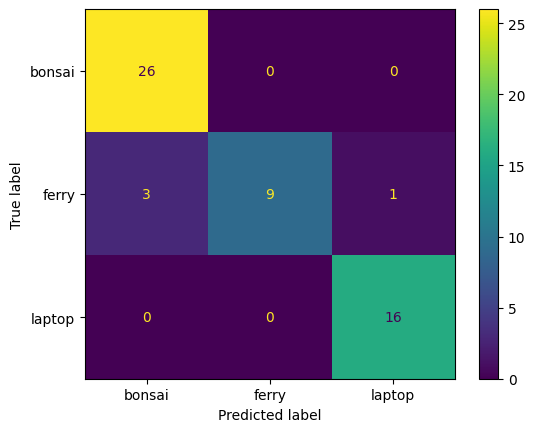

In [24]:
##############################################################################
# TODO: Plot confusion the matrix                                            #
##############################################################################
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## Task 1.3: Extending the approach to the 6 classes

**Extend the implemented approach to the 6 categories available** in `101_Caltech_Subset`. **Compute the performance metrics** and compare them to those obtained in the 3-class implementation. Why do you think that there is a difference in accuracy in the detection of the classes that were common between the two models?

In [ ]:
##############################################################################
# TODO: Extend to the whole subset of 6 classes
##############################################################################
# Load data with the following:
X, y = import_selected_data('101_Caltech_Subset')
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# 2: Digit classification with a Multi-Layer Perceptron (MLP)

Adapted from [here](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html).

In the past lab tutorial, we have trained an SVM classifier on the **MNIST  dataset of digits** using the pixel intensities directly as feature descriptors. Let's now try to **implement a multi-layer perceptron (MLP)** for the same task.

First, let's load the training set as we did last time:

In [ ]:
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load

%matplotlib inline

train_data = np.genfromtxt('sample_data/mnist_train_small.csv', delimiter=",")
X_train = train_data[:, 1:]
y_train = train_data[:, 0]

# Rescale the intensities, cast the labels to int
X_train = X_train / 255.
y_train = y_train.astype(int)

print('X_train shape =', X_train.shape)
print('y_train shape =', y_train.shape)

X_train shape = (20000, 784)
y_train shape = (20000,)


Let's reduce the size of the training set for faster computing:

In [ ]:
n_train_samples = 2000
X_train = X_train[:n_train_samples]
y_train = y_train[:n_train_samples]

Let's now see how the data appears by reshaping the first few samples into 28x28 pixels images:

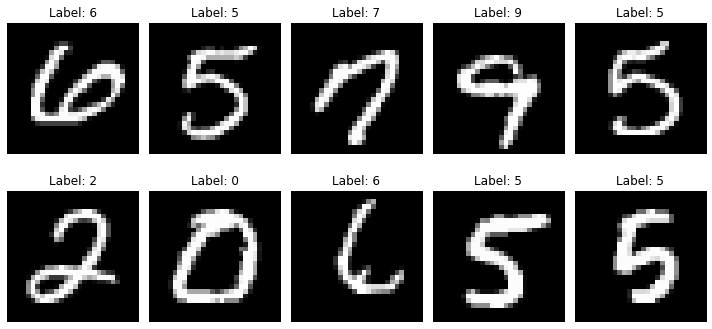

In [ ]:
X_train_img = X_train.reshape(-1, 28, 28)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_train_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_train[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

Let's also load and rescale the test set:

In [ ]:
test_data = np.genfromtxt('sample_data/mnist_test.csv', delimiter=",")
X_test = test_data[:, 1:]
y_test = test_data[:, 0]

# Rescale the intensities, cast the labels to int
X_test = X_test / 255.
y_test = y_test.astype(int)

To implement a MLP classifier we can simply create a `sklearn.neural_network.MLPClassifier` object. 

Spend some time on the online documentation to understand the available parameters. Note that the `sklearn`'s syntax to train and test an MLP is conveniently the same as the one used for the SVM classifier. Also note that in this case we have set `verbose=True`, which will output the result of each iteration:

In [ ]:
# Create a classifier: Multi-Layer Perceptron
classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.1)

classifier.fit(X_train, y_train)

Iteration 1, loss = 1.58118924
Iteration 2, loss = 0.54612944
Iteration 3, loss = 0.37780862
Iteration 4, loss = 0.29598466
Iteration 5, loss = 0.24614417
Iteration 6, loss = 0.21136244
Iteration 7, loss = 0.18485921
Iteration 8, loss = 0.15733834
Iteration 9, loss = 0.13822357
Iteration 10, loss = 0.12296916
Iteration 11, loss = 0.11071803
Iteration 12, loss = 0.09452118
Iteration 13, loss = 0.08721141
Iteration 14, loss = 0.07471857
Iteration 15, loss = 0.06431537
Iteration 16, loss = 0.05747237
Iteration 17, loss = 0.05038327
Iteration 18, loss = 0.04568739
Iteration 19, loss = 0.03946309
Iteration 20, loss = 0.03580506
Iteration 21, loss = 0.03253728
Iteration 22, loss = 0.02898135
Iteration 23, loss = 0.02622320
Iteration 24, loss = 0.02433105
Iteration 25, loss = 0.02241841
Iteration 26, loss = 0.02121286
Iteration 27, loss = 0.01966763
Iteration 28, loss = 0.01816179
Iteration 29, loss = 0.01687970
Iteration 30, loss = 0.01569226
Iteration 31, loss = 0.01494252
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True)

In most practical cases, **once a model has been trained it also has to be saved in a persistent format**, allowing to use it on test data without having to re-train it from scratch each time. 

Out of the many possible ways to do this, the most common one when dealing with `sklearn` models is to use the `dump` function from `joblib` library: 

In [ ]:
dump(classifier, 'MLP_MNIST.joblib') 

['MLP_MNIST.joblib']

In the *Files* folder in the toolbar on the left, you should see the generated model file.

To load a model from a file, you can use the `load` function:

In [ ]:
classifier = load('MLP_MNIST.joblib') 

Note that in this case there was no need to do this, since the model is available in the variable named classifier. For more information on storing/loading models (also called *model persistence*), please have a look at [this guide](https://scikit-learn.org/stable/modules/model_persistence.html).

Let's now run the model on the test set:

In [ ]:
y_pred = classifier.predict(X_test)

Let's check the result qualitatively on a small (and randomly shuffled) subset of the test set:

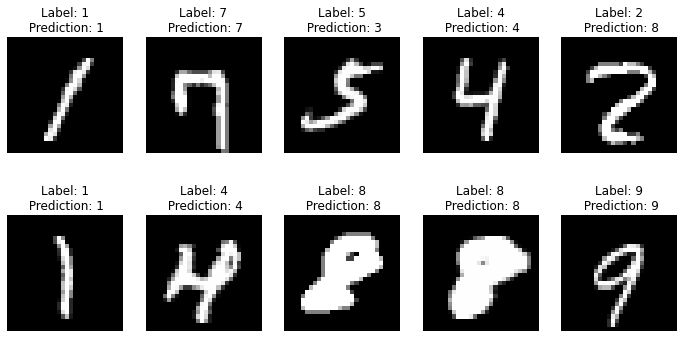

In [ ]:
X_test, y_test, y_pred = shuffle(X_test, y_test, y_pred)
X_test_img = X_test.reshape(-1, 28, 28)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_test[i]}\n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

We can now plot the confusion matrix computed on the whole test set:

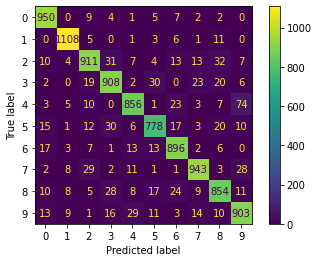

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Finally, let's compute some performance metrics:

In [ ]:
print(f"""Classification report for classifier {classifier}:\n
      {metrics.classification_report(y_test, y_pred)}""")

Classification report for classifier MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True):

                    precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.97      0.98      0.97      1135
           2       0.90      0.88      0.89      1032
           3       0.89      0.90      0.89      1010
           4       0.92      0.87      0.89       982
           5       0.90      0.87      0.89       892
           6       0.91      0.94      0.92       958
           7       0.93      0.92      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.87      0.89      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



A technique that can be extremely useful to inspect a trained neural network is to look at the learned weights. For example, if weights look unstructured, maybe some were not used at all; or if very large coefficients exist, maybe regularization was too low or the learning rate too high.

We can do this assessment qualitatively by **visualising the MLP weights for the neurons of the first layer**. As we have seen, in MNIST the input data consists of 28x28 pixel images, leading to a feature descriptor of 784 dimensions. Therefore, each of the 50 neurons of the first layer has 784 weights, which we can reshape into a 28x28 pixel image. 

Let's plot the weights of the first 16 neurons:

Shape of first layer coefficients = (784, 50)


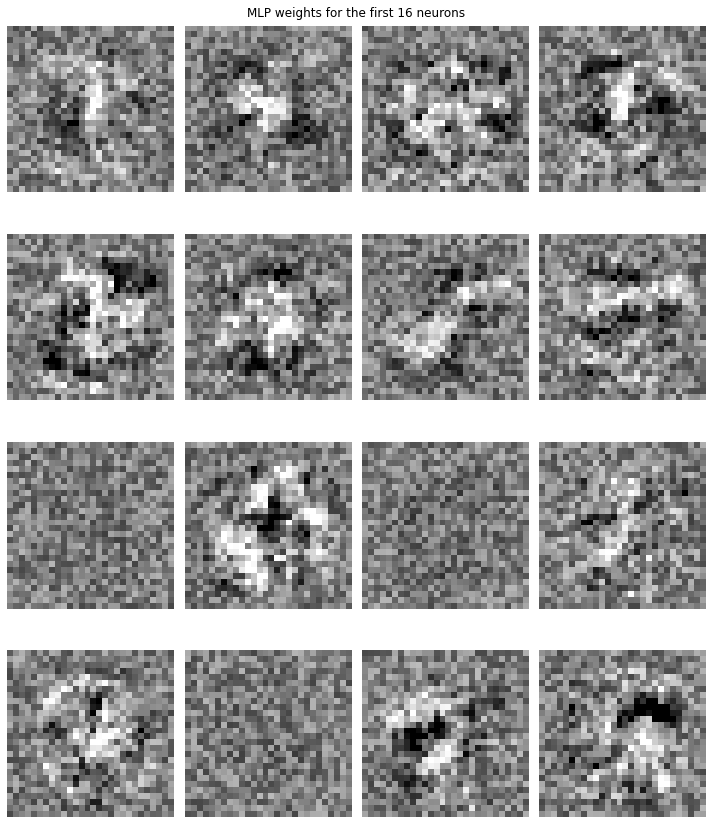

In [ ]:
print('Shape of first layer coefficients =', classifier.coefs_[0].shape)

fig, axes = plt.subplots(4, 4, figsize=(10, 12))
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = classifier.coefs_[0].min(), classifier.coefs_[0].max()
for coef, ax in zip(classifier.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap='gray', vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_axis_off()

fig.suptitle('MLP weights for the first 16 neurons')
fig.tight_layout()
plt.show()

Despite this MLP was trained for a very short amount of time, some patterns have already emerged, highlighting positions of the image that are useful to differentiate the different digits.

## Task 2.1: Implementing a different MLP model

Also for the MLP, try to **modify the hyper-parameters** (e.g. number of hidden layers and/or number of neurons per hidden layer) and see how this affects the overall accuracy.

In [ ]:
##############################################################################
# TODO: Implement a different MLP model                                      #
##############################################################################
# Replace above with
classifier_new = MLPClassifier(hidden_layer_sizes=(50, 100), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.1)

classifier_new.fit(X_train, y_train)
y_pred_new = classifier_new.predict(X_test)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

print(f"""Classification report for classifier {classifier_new}:\n
      {metrics.classification_report(y_test, y_pred_new)}""")

Iteration 1, loss = 1.90650246
Iteration 2, loss = 0.84687591
Iteration 3, loss = 0.44607889
Iteration 4, loss = 0.29002325
Iteration 5, loss = 0.22029303
Iteration 6, loss = 0.16877027
Iteration 7, loss = 0.12262109
Iteration 8, loss = 0.09752689
Iteration 9, loss = 0.07429859
Iteration 10, loss = 0.05666777
Iteration 11, loss = 0.04624172
Iteration 12, loss = 0.03654108
Iteration 13, loss = 0.02911866
Iteration 14, loss = 0.02309432
Iteration 15, loss = 0.01869345
Iteration 16, loss = 0.01686189
Iteration 17, loss = 0.01312340
Iteration 18, loss = 0.01136635
Iteration 19, loss = 0.00959750
Iteration 20, loss = 0.00821940
Iteration 21, loss = 0.00717161
Iteration 22, loss = 0.00648275
Iteration 23, loss = 0.00576040
Iteration 24, loss = 0.00522095
Iteration 25, loss = 0.00477951
Iteration 26, loss = 0.00438242
Iteration 27, loss = 0.00404622
Iteration 28, loss = 0.00378762
Iteration 29, loss = 0.00356710
Iteration 30, loss = 0.00330348
Iteration 31, loss = 0.00311609
Iteration 32, los